# Elo Merchant Category Recommendation - LightGBM without outliers
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import time
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, RepeatedKFold

%matplotlib inline
warnings.simplefilter('ignore', UserWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_date'] = pd.to_datetime(df[source_column])
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_month_start'] = df[source_column].dt.is_month_start
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_weekend'] = (df[source_column].dt.weekday >=5).astype(int)
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour

    return df

## Input data preparation
https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting
https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/75034
### Transactions
#### Load

In [4]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 289.84 MB
Reduced memory usage: 70.52 MB (75.7% reduction)
Starting memory usage: 325.36 MB
Reduced memory usage: 96.86 MB (70.2% reduction)


In [5]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

#### Preparation

In [ ]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

In [ ]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(len(df_new_trans)))

In [ ]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'N': 0, 'Y': 1})
df_hist_trans['category_2'] = pd.to_numeric(df_hist_trans['category_2'])
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [ ]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'N': 0, 'Y': 1})
df_new_trans['category_2'] = pd.to_numeric(df_new_trans['category_2'])
df_new_trans['category_3'] = df_new_trans['category_3'].map({'A': 0, 'B': 1, 'C': 2})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [ ]:
def get_time_of_month(day_of_month):
    if day_of_month < 10:
        time_of_month = 0 # Beginning
    elif day_of_month >= 10 and day_of_month < 20:
        time_of_month = 1 # Middle
    else:
        time_of_month = 2 # End
    return time_of_month

In [ ]:
df_hist_trans['purchase_part_of_month'] = df_hist_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [ ]:
df_new_trans['purchase_part_of_month'] = df_new_trans['purchase_day'].apply(lambda x: get_time_of_month(x))

In [ ]:
df_new_trans[:3]

In [ ]:
df_hist_trans[:3]

##### Calculating the number of transactions

In [ ]:
df_hist_gb_card_id = df_hist_trans.groupby("card_id").size().reset_index().set_index('card_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [ ]:
df_hist_gb_card_id[:3]

In [ ]:
df_hist_gb_merchant_id = df_hist_trans.groupby("merchant_id").size().reset_index().set_index('merchant_id').sort_index(axis=1).rename({0:'number_of_transactions'}, axis=1)

In [ ]:
df_hist_gb_merchant_id[:3]

##### Aggregation

In [ ]:
df_hist_trans = pd.merge(df_hist_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [ ]:
df_new_trans = pd.merge(df_new_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])

In [ ]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],
        'active_months_lag3': ['sum', 'mean'],
        'active_months_lag6': ['sum', 'mean'],
        'active_months_lag12': ['sum', 'mean'],
        
        'avg_sales_lag3': ['sum', 'mean'],
        'avg_sales_lag6': ['sum', 'mean'], 
        'avg_sales_lag12': ['sum', 'mean'],
        
        'avg_purchases_lag3': ['sum', 'mean'], 
        'avg_purchases_lag6': ['sum', 'mean'], 
        'avg_purchases_lag12': ['sum', 'mean'], 

        'card_id': ['size'],
        'category_1_trans': ['sum', 'mean'],
        'category_1_merch': ['sum', 'mean'],
        'category_2_trans': ['sum', 'mean'],
        'category_2_merch': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],
        'category_4': ['sum', 'mean'], 
        
        'city_id_trans': ['nunique'],
        'city_id_merch': ['nunique'],
        
        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],

        'merchant_id': ['nunique'],
        'merchant_category_id_trans': ['nunique'],
        'merchant_category_id_merch': ['nunique'],
        'merchant_group_id': ['nunique'],
        'month_lag': ['max', 'min', 'mean', 'var'],
        
        'most_recent_sales_range': ['sum', 'mean', 'max', 'min', 'std'],
        'most_recent_purchases_range': ['sum', 'mean', 'max', 'min', 'std'],
        
        'numerical_1': ['mean', 'median', 'max', 'min', 'std'],
        'numerical_2': ['mean', 'median', 'max', 'min', 'std'],
        'number_of_transactions': ['mean', 'median', 'max', 'min', 'std'],

        'state_id_trans': ['nunique'],
        'state_id_merch': ['nunique'],
        'subsector_id_trans': ['nunique'],
        'subsector_id_merch': ['nunique'],
        
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std', 'nunique'],
        'purchase_quarter': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_part_of_month': ['mean', 'median'],
        
        'purchase_weekend': ['sum', 'mean']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [ ]:
%%time
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

In [ ]:
df_new_trans.to_csv('preprocessed/trans_merch_new_agg.csv')

In [ ]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
%%time
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

In [ ]:
df_hist_trans.to_csv('preprocessed/trans_merch_hist_agg.csv')

### Train and test data
#### Load

In [7]:
df_train = pd.read_csv("preprocessed/train_parsed_outlier_marked.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

#### Preparation

In [ ]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

In [ ]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

In [ ]:
df_train['elapsed_days'] = (np.datetime64('2018-02-01') - df_train['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)
df_test['elapsed_days'] = (np.datetime64('2018-02-01') - df_test['first_active_month'].values.astype('datetime64[D]')).astype(np.int64)

In [ ]:
df_train[:3]

In [ ]:
df_test[:3]

In [ ]:
df_train["year"] = df_train["first_active_month"].dt.year
df_train["month"] = df_train["first_active_month"].dt.month

df_train['days_feature1'] = df_train['elapsed_days'] * df_train['feature_1']
df_train['days_feature2'] = df_train['elapsed_days'] * df_train['feature_2']
df_train['days_feature3'] = df_train['elapsed_days'] * df_train['feature_3']

In [ ]:
df_test["year"] = df_test["first_active_month"].dt.year
df_test["month"] = df_test["first_active_month"].dt.month

df_test['days_feature1'] = df_test['elapsed_days'] * df_test['feature_1']
df_test['days_feature2'] = df_test['elapsed_days'] * df_test['feature_2']
df_test['days_feature3'] = df_test['elapsed_days'] * df_test['feature_3']

In [ ]:
df_train = pd.merge(df_train, df_hist_gb_card_id, left_index=True, right_index=True, how='left')
df_test = pd.merge(df_test, df_hist_gb_card_id, left_index=True, right_index=True, how='left')

In [ ]:
df_train['outlier'] = 0
df_train.loc[df_train['target'] < -30, 'outlier'] = 1

In [ ]:
print('There are {:,} records marked as outlier.'.format(df_train[df_train['outlier'] == 1]['target'].count()))

In [ ]:
df_train.to_csv('preprocessed/train_parsed_outlier_marked.csv')
df_test.to_csv('preprocessed/test_parsed.csv')

### Merchants

#### Preparation

In [ ]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")

In [ ]:
df_merch = df_merch.groupby(df_merch.index).first()

In [ ]:
df_merch[:3]

In [ ]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [ ]:
df_merch = pd.merge(df_merch, df_hist_gb_merchant_id, left_index=True, right_index=True, how='left')

### LynxKite export

In [8]:
df_lk_train = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_train.csv", index_col="card_id")
df_lk_test = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_test.csv", index_col="card_id")

In [10]:
df_lk_train.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)
df_lk_test.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)

### Merging

In [11]:
df_train = pd.merge(df_train, df_lk_train, on='card_id', how='left')
df_test = pd.merge(df_test, df_lk_test, on='card_id', how='left')

In [12]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [13]:
print('There are {:,} outliers in the training set.'.format(len(df_train[df_train['target'] < -30])))

There are 2,207 outliers in the training set.


In [14]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Starting memory usage: 212.97 MB
Reduced memory usage: 127.67 MB (40.1% reduction)
Starting memory usage: 128.51 MB
Reduced memory usage: 81.70 MB (36.4% reduction)


In [30]:
df_train_wo_outliers = df_train[df_train['target'] > -30]

## Training
Training using LightGBM without outliers

In [33]:
df_target = df_train_wo_outliers['target']

use_cols = [c for c in df_train_wo_outliers.columns if c not in ['card_id', 'first_active_month', 'target', 'outlier', 'viral_outlier_test', 'viral_roles']]
features = list(df_train_wo_outliers[use_cols].columns)

In [34]:
df_train_wo_outliers[features].shape, df_test[features].shape

((199710, 286), (123623, 286))

### LightGBM - KFold
[Difference between KFold & StratifiedKFold](https://www.kaggle.com/ogrellier/kfold-or-stratifiedkfold)

In [35]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train_wo_outliers))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_wo_outliers.values, df_target.values)):
    print("Fold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train_wo_outliers.iloc[trn_idx][features], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_wo_outliers.iloc[val_idx][features], label=df_target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train_wo_outliers.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold 1.
Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 1.63763	valid_1's rmse: 1.64715
[200]	training's rmse: 1.59925	valid_1's rmse: 1.61346
[300]	training's rmse: 1.57791	valid_1's rmse: 1.59637
[400]	training's rmse: 1.56407	valid_1's rmse: 1.58657
[500]	training's rmse: 1.55394	valid_1's rmse: 1.58039
[600]	training's rmse: 1.54581	valid_1's rmse: 1.57624
[700]	training's rmse: 1.53885	valid_1's rmse: 1.57321
[800]	training's rmse: 1.53274	valid_1's rmse: 1.57091
[900]	training's rmse: 1.52715	valid_1's rmse: 1.56929
[1000]	training's rmse: 1.52194	valid_1's rmse: 1.56783
[1100]	training's rmse: 1.51706	valid_1's rmse: 1.5668
[1200]	training's rmse: 1.51246	valid_1's rmse: 1.56602
[1300]	training's rmse: 1.50806	valid_1's rmse: 1.56542
[1400]	training's rmse: 1.50385	valid_1's rmse: 1.5649
[1500]	training's rmse: 1.49981	valid_1's rmse: 1.56454
Early stopping, best iteration is:
[1568]	training's rmse: 1.49719	valid_1's rmse: 1.56433
Fold 2.
Tr

In [36]:
np.sqrt(mean_squared_error(oof, df_target))

1.5579965471370778

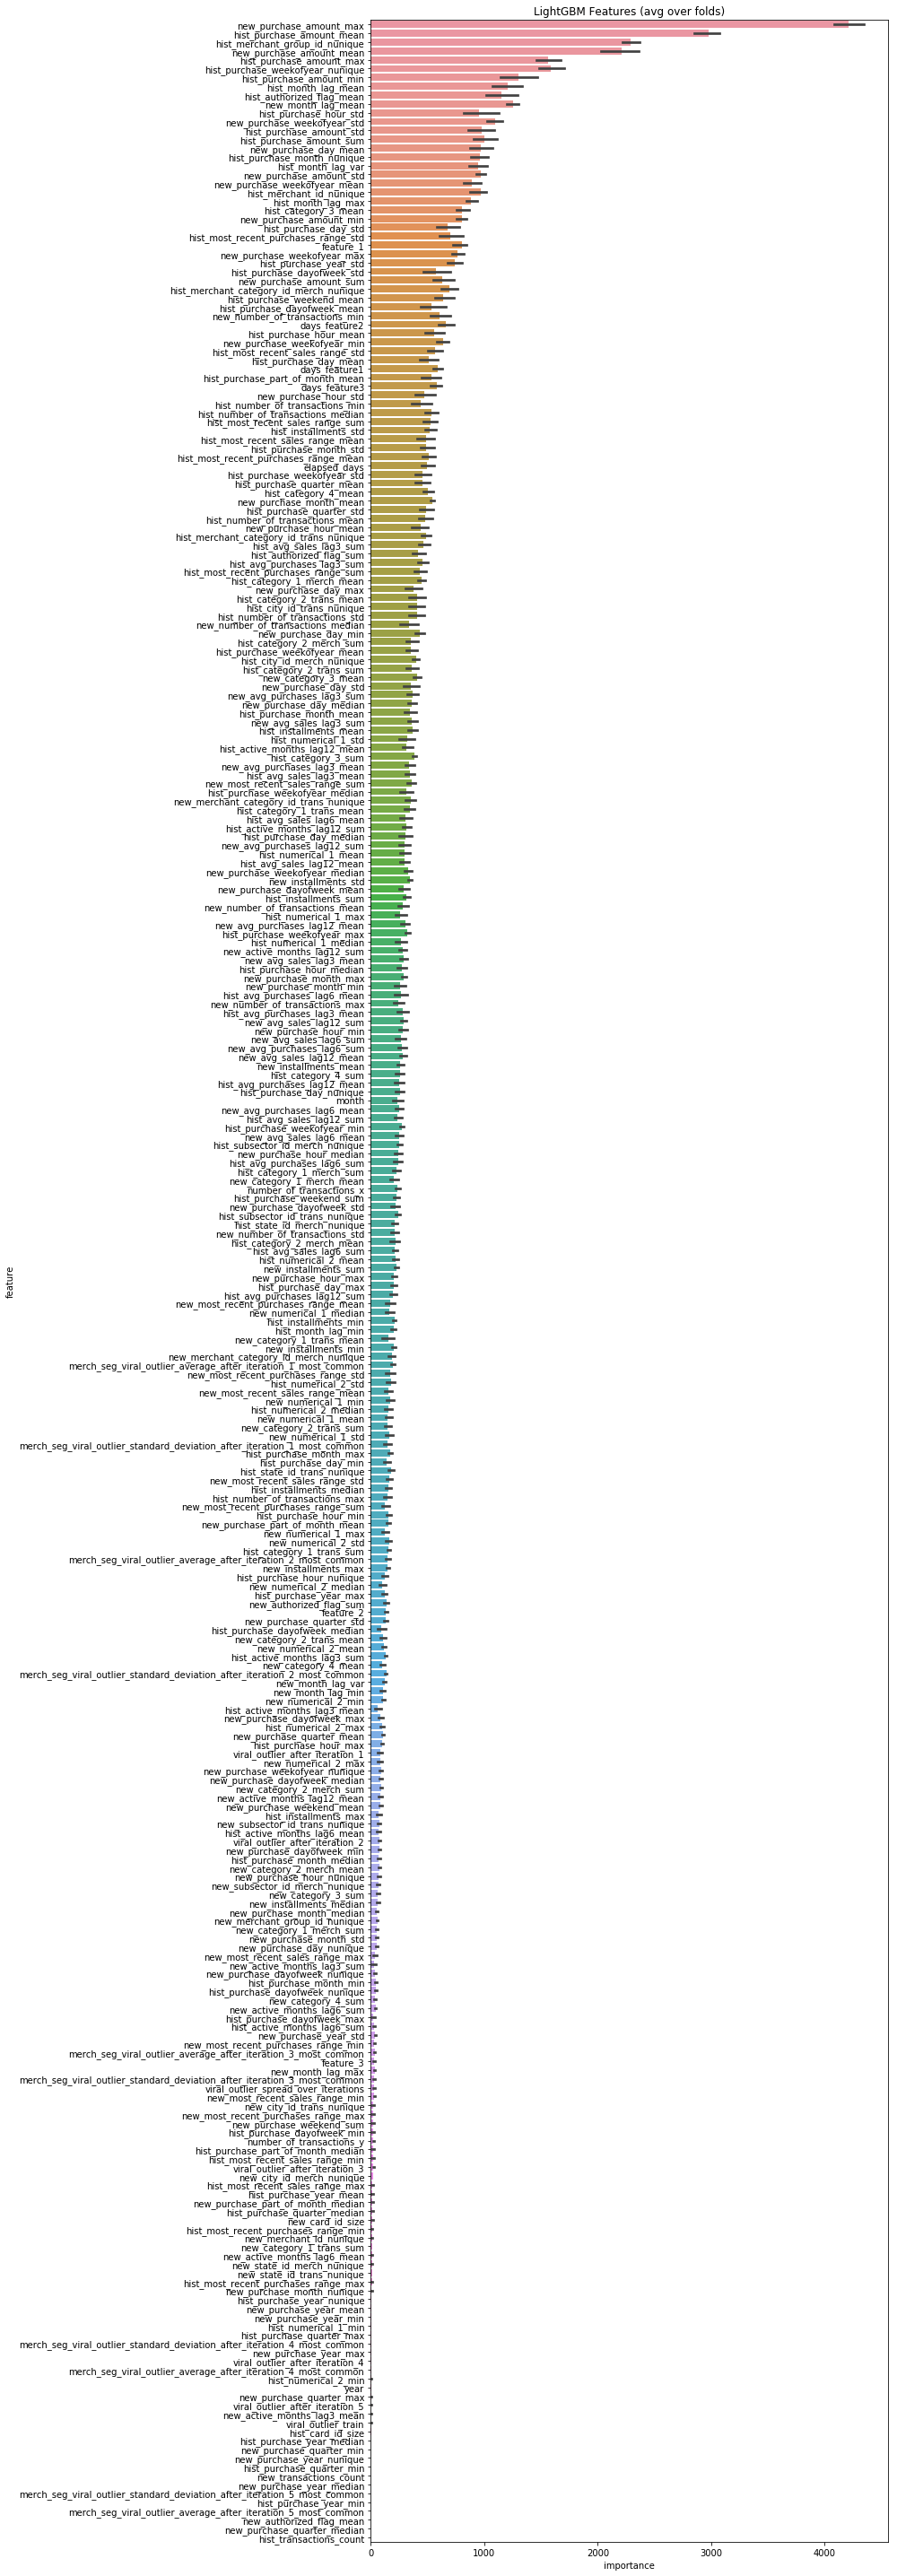

In [40]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [41]:
clf.save_model('models/lightgbm_wo_outliers_with_lk.txt')

### LightGBM - KFold 2.
[Change in Hyper Parameters using kernel](https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending/output)

In [46]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
#folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=15)

oof = np.zeros(len(df_train_wo_outliers))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_wo_outliers.values, df_target.values)):
    param = {
        'bagging_seed': int(2**fold_),
        'boosting': 'gbdt',
        'colsample_bytree': 0.5665320670155495,
        'drop_seed': int(2**fold_),
        'learning_rate': 0.01,
        'max_depth': 7,
        'metric': 'rmse',
        'min_child_weight': 41.9612869171337,
        'min_data_in_leaf': 21,
        'min_split_gain': 9.820197773625843,
        'num_leaves': 63,
        'objective': 'regression',
        'other_rate': 0.0721768246018207,
        'subsample': 0.9855232997390695,
        'reg_alpha': 9.677537745007898,
        'reg_lambda': 8.2532317400459,
        'seed': int(2**fold_),
        'task': 'train',
        'top_rate': 0.9064148448434349,
        'verbose': -1
    }

    print("Fold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=df_target.iloc[val_idx])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train_wo_outliers.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.71341	valid_1's rmse: 1.7209
Early stopping, best iteration is:
[9]	training's rmse: 1.71663	valid_1's rmse: 1.72071
Fold 2.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.71235	valid_1's rmse: 1.72077
[200]	training's rmse: 1.71011	valid_1's rmse: 1.72081
Early stopping, best iteration is:
[108]	training's rmse: 1.71207	valid_1's rmse: 1.72075
Fold 3.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.71793	valid_1's rmse: 1.70133
Early stopping, best iteration is:
[8]	training's rmse: 1.72156	valid_1's rmse: 1.70115
Fold 4.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.71239	valid_1's rmse: 1.72113
Early stopping, best iteration is:
[1]	training's rmse: 1.71695	valid_1's rmse: 1.7209
Fold 5.
Training until validation scores don't improve for 100 rounds.
[100]	training's r

### LightGBM - StratifiedKFold

In [47]:
folds = StratifiedKFold(n_splits=5, shuffle = True, random_state=15)

oof = np.zeros(len(df_train_wo_outliers))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_wo_outliers.values, df_target.values)):
    param = {
        'bagging_seed': int(2**fold_),
        'boosting': 'gbdt',
        'colsample_bytree': 0.5665320670155495,
        'drop_seed': int(2**fold_),
        'learning_rate': 0.01,
        'max_depth': 7,
        'metric': 'rmse',
        'min_child_weight': 41.9612869171337,
        'min_data_in_leaf': 21,
        'min_split_gain': 9.820197773625843,
        'num_leaves': 63,
        'objective': 'regression',
        'other_rate': 0.0721768246018207,
        'subsample': 0.9855232997390695,
        'reg_alpha': 9.677537745007898,
        'reg_lambda': 8.2532317400459,
        'seed': int(2**fold_),
        'task': 'train',
        'top_rate': 0.9064148448434349,
        'verbose': -1
    }

    print("Fold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=df_target.iloc[val_idx])
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train_wo_outliers.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

## Outlier selection

In [ ]:
df_train = df_train.drop(['card_id', 'first_active_month'], axis = 1)
df_test = df_test.drop(['card_id', 'first_active_month'], axis = 1)

In [ ]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

In [ ]:
for feature in ['feature_1', 'feature_2', 'feature_3']:
    order_label = df_train.groupby([feature])['outliers'].mean()
    df_train[feature] = df_train[feature].map(order_label)
    df_test[feature] = df_test[feature].map(order_label)

In [ ]:
features = [c for c in df_train.columns if c not in ['target', 'outliers']]

In [ ]:
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4950)
oof_2 = np.zeros(len(df_train))
predictions_2 = np.zeros(len(df_test))
feature_importance_df_2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_target.values)):
    
    print("Fold {}.".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=df_target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=df_target.iloc[val_idx])
    
    param ={
        'bagging_seed': int(2**fold_),
        'boosting': 'goss',
        'colsample_bytree': 0.5665320670155495,
        'drop_seed': int(2**fold_),
        'learning_rate': 0.01,
        'max_depth': 7,
        'metric': 'rmse',
        'min_child_weight': 41.9612869171337,
        'min_data_in_leaf': 21,
        'min_split_gain': 9.820197773625843,
        'num_leaves': 63,
        'objective': 'regression',
        'other_rate': 0.0721768246018207,
        'reg_alpha': 9.677537745007898,
        'reg_lambda': 8.2532317400459,
        'seed': int(2**fold_),
        'subsample': 0.9855232997390695,
        'task': 'train',
        'top_rate': 0.9064148448434349,
        'verbose': -1
    }
        
    num_round = 10000
    clf_r = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 200)
    oof_2[val_idx] = clf_r.predict(df_train.iloc[val_idx][features], num_iteration=clf_r.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf_r.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df_2 = pd.concat([feature_importance_df_2, fold_importance_df], axis=0)
    
    predictions_2 += clf_r.predict(df_test[features], num_iteration=clf_r.best_iteration) / (5 * 2)

In [ ]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof_2, df_target)**0.5))

In [ ]:
cols = (feature_importance_df_2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_2.loc[feature_importance_df_2.Feature.isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
from sklearn.linear_model import BayesianRidge

train_stack = np.vstack([oof, oof_2]).transpose()
test_stack = np.vstack([predictions, predictions_2]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=1, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("Fold {}.".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], df_target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], df_target.iloc[val_idx].values

    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)

    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5

In [ ]:
pred_3_cv = np.sqrt(mean_squared_error(df_target.values, oof_stack))

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions_3
df_sub.to_csv("output/lgbm_{}.csv".format(pred_3_cv), index=False)

## Feature selection

In [ ]:
cols = ['feature_1', 'feature_2', 'feature_3', 'year', 'month', 'number_of_transactions', 'hist_transactions_count', 'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_active_months_lag3_sum', 'hist_active_months_lag3_mean', 'hist_active_months_lag6_sum', 'hist_active_months_lag6_mean', 'hist_active_months_lag12_sum', 'hist_active_months_lag12_mean', 'hist_avg_sales_lag3_sum', 'hist_avg_sales_lag3_mean', 'hist_avg_sales_lag6_sum', 'hist_avg_sales_lag6_mean', 'hist_avg_sales_lag12_sum', 'hist_avg_sales_lag12_mean', 'hist_avg_purchases_lag3_sum', 'hist_avg_purchases_lag3_mean', 'hist_avg_purchases_lag6_sum', 'hist_avg_purchases_lag6_mean', 'hist_avg_purchases_lag12_sum', 'hist_avg_purchases_lag12_mean', 'hist_category_1_trans_sum', 'hist_category_1_trans_mean', 'hist_category_1_merch_sum', 'hist_category_1_merch_mean', 'hist_category_2_trans_sum', 'hist_category_2_trans_mean', 'hist_category_2_merch_sum', 'hist_category_2_merch_mean', 'hist_category_3_sum', 'hist_category_3_mean', 'hist_category_4_sum', 'hist_category_4_mean', 'hist_city_id_trans_nunique', 'hist_city_id_merch_nunique', 'hist_installments_sum', 'hist_installments_median', 'hist_installments_mean', 'hist_installments_max', 'hist_installments_min', 'hist_installments_std', 'hist_merchant_id_nunique', 'hist_merchant_category_id_trans_nunique', 'hist_merchant_category_id_merch_nunique', 'hist_merchant_group_id_nunique', 'hist_month_lag_min', 'hist_month_lag_max', 'hist_month_lag_mean', 'hist_most_recent_sales_range_sum', 'hist_most_recent_sales_range_mean', 'hist_most_recent_sales_range_max', 'hist_most_recent_sales_range_min', 'hist_most_recent_sales_range_std', 'hist_most_recent_purchases_range_sum', 'hist_most_recent_purchases_range_mean', 'hist_most_recent_purchases_range_max', 'hist_most_recent_purchases_range_min', 'hist_most_recent_purchases_range_std', 'hist_numerical_1_mean', 'hist_numerical_1_median', 'hist_numerical_1_max', 'hist_numerical_1_min', 'hist_numerical_1_std', 'hist_numerical_2_mean', 'hist_numerical_2_median', 'hist_numerical_2_max', 'hist_numerical_2_min', 'hist_numerical_2_std', 'hist_number_of_transactions_mean', 'hist_number_of_transactions_median', 'hist_number_of_transactions_max', 'hist_number_of_transactions_min', 'hist_number_of_transactions_std', 'hist_state_id_trans_nunique', 'hist_state_id_merch_nunique', 'hist_subsector_id_trans_nunique', 'hist_subsector_id_merch_nunique', 'hist_purchase_amount_sum', 'hist_purchase_amount_mean', 'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_std', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_max', 'hist_purchase_year_min', 'hist_purchase_year_std', 'hist_purchase_month_mean', 'hist_purchase_month_median', 'hist_purchase_month_max', 'hist_purchase_month_min', 'hist_purchase_month_std', 'hist_purchase_day_mean', 'hist_purchase_day_median', 'hist_purchase_day_max', 'hist_purchase_day_min', 'hist_purchase_day_std', 'hist_purchase_hour_mean', 'hist_purchase_hour_median', 'hist_purchase_hour_max', 'hist_purchase_hour_min', 'hist_purchase_hour_std', 'hist_purchase_weekofyear_mean', 'hist_purchase_weekofyear_median', 'hist_purchase_weekofyear_max', 'hist_purchase_weekofyear_min', 'hist_purchase_weekofyear_std', 'hist_purchase_dayofweek_mean', 'hist_purchase_dayofweek_median', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'hist_purchase_dayofweek_std', 'hist_purchase_quarter_mean', 'hist_purchase_quarter_median', 'hist_purchase_quarter_max', 'hist_purchase_quarter_min', 'hist_purchase_quarter_std', 'hist_purchase_part_of_month_mean', 'hist_purchase_part_of_month_median', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_active_months_lag3_sum', 'new_active_months_lag3_mean', 'new_active_months_lag6_sum', 'new_active_months_lag6_mean', 'new_active_months_lag12_sum', 'new_active_months_lag12_mean', 'new_avg_sales_lag3_sum', 'new_avg_sales_lag3_mean', 'new_avg_sales_lag6_sum', 'new_avg_sales_lag6_mean', 'new_avg_sales_lag12_sum', 'new_avg_sales_lag12_mean', 'new_avg_purchases_lag3_sum', 'new_avg_purchases_lag3_mean', 'new_avg_purchases_lag6_sum', 'new_avg_purchases_lag6_mean', 'new_avg_purchases_lag12_sum', 'new_avg_purchases_lag12_mean', 'new_category_1_trans_sum', 'new_category_1_trans_mean', 'new_category_1_merch_sum', 'new_category_1_merch_mean', 'new_category_2_trans_sum', 'new_category_2_trans_mean', 'new_category_2_merch_sum', 'new_category_2_merch_mean', 'new_category_3_sum', 'new_category_3_mean', 'new_category_4_sum', 'new_category_4_mean', 'new_city_id_trans_nunique', 'new_city_id_merch_nunique', 'new_installments_sum', 'new_installments_median', 'new_installments_mean', 'new_installments_max', 'new_installments_min', 'new_installments_std', 'new_merchant_id_nunique', 'new_merchant_category_id_trans_nunique', 'new_merchant_category_id_merch_nunique', 'new_merchant_group_id_nunique', 'new_month_lag_min', 'new_month_lag_max', 'new_month_lag_mean', 'new_most_recent_sales_range_sum', 'new_most_recent_sales_range_mean', 'new_most_recent_sales_range_max', 'new_most_recent_sales_range_min', 'new_most_recent_sales_range_std', 'new_most_recent_purchases_range_sum', 'new_most_recent_purchases_range_mean', 'new_most_recent_purchases_range_max', 'new_most_recent_purchases_range_min', 'new_most_recent_purchases_range_std', 'new_numerical_1_mean', 'new_numerical_1_median', 'new_numerical_1_max', 'new_numerical_1_min', 'new_numerical_1_std', 'new_numerical_2_mean', 'new_numerical_2_median', 'new_numerical_2_max', 'new_numerical_2_min', 'new_numerical_2_std', 'new_number_of_transactions_mean', 'new_number_of_transactions_median', 'new_number_of_transactions_max', 'new_number_of_transactions_min', 'new_number_of_transactions_std', 'new_state_id_trans_nunique', 'new_state_id_merch_nunique', 'new_subsector_id_trans_nunique', 'new_subsector_id_merch_nunique', 'new_purchase_amount_sum', 'new_purchase_amount_mean', 'new_purchase_amount_max', 'new_purchase_amount_min', 'new_purchase_amount_std', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'new_purchase_year_std', 'new_purchase_month_mean', 'new_purchase_month_median', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_month_std', 'new_purchase_day_mean', 'new_purchase_day_median', 'new_purchase_day_max', 'new_purchase_day_min', 'new_purchase_day_std', 'new_purchase_hour_mean', 'new_purchase_hour_median', 'new_purchase_hour_max', 'new_purchase_hour_min', 'new_purchase_hour_std', 'new_purchase_weekofyear_mean', 'new_purchase_weekofyear_median', 'new_purchase_weekofyear_max', 'new_purchase_weekofyear_min', 'new_purchase_weekofyear_std', 'new_purchase_dayofweek_mean', 'new_purchase_dayofweek_median', 'new_purchase_dayofweek_max', 'new_purchase_dayofweek_min', 'new_purchase_dayofweek_std', 'new_purchase_quarter_mean', 'new_purchase_quarter_median', 'new_purchase_quarter_max', 'new_purchase_quarter_min', 'new_purchase_quarter_std', 'new_purchase_part_of_month_mean', 'new_purchase_part_of_month_median']
X = df_train[cols].copy()
y = df_train.target

In [ ]:
X.columns.tolist()

### 6 Ways for Feature Selection
https://www.kaggle.com/sz8416/6-ways-for-feature-selection

#### Pearson correlation

In [ ]:
def cor_selector(X, y, limit=500):
    cor_list = []
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-limit:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns.tolist()]
    return cor_support, cor_feature, cor_list

In [ ]:
cor_support, cor_feature, cor_value = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

In [ ]:
df_c_supp = pd.DataFrame(data={
    'variable_name': cor_feature,
    'corr_coeff': cor_value
})

df_c_supp.sort_values('corr_coeff', axis=0, inplace=True, ascending=False)

In [ ]:
df_c_supp[:5]

In [ ]:
df_c_supp.plot.bar(x='variable_name', y='corr_coeff', rot=60, figsize=(50, 5))

In [ ]:
cols_2_use = df_c_supp[df_c_supp['corr_coeff'] > 0]['variable_name']
len(df_c_supp[df_c_supp['corr_coeff'] > 0])

In [ ]:
list(cols_2_use)